In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pyranges as pr
import itertools
import functions as fn
from collections import defaultdict


In [2]:
wd = "/Genomics/kocherlab/bjarnold/Nmel"
bioreps = ['F1', 'F2', 'F3']

macs_peaks_files = [f"{wd}/MACS2/Nmel-{b}_peaks.narrowPeak" for b in bioreps]
# 1. chromosome
# 2. start
# 3. end
# 4. name
# 5. score
# 6. strand
# 7. signalValue - measurement of overall enrichment for the region
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - Point-source called for this peak; -based offset from chromStart

genrich_peaks_files = [f"{wd}/genrich_single/Nmel-{b}_peaks.narrowPeak" for b in bioreps]
# 1. chromosome
# 2. chromStart
# 3. chromEnd
# 4. name
# 5. score
# 6. strand
# 7. signalValue - total area under the curve (AUC)
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - summit position (0-based offset from chromStart)
genrich_multi_peak_file = f"{wd}/genrich_multi/Nmel_peaks.narrowPeak"

genrich_pileup_files = [f"{wd}/genrich_single/Nmel-{b}_pileups.txt" for b in bioreps]

chr1_test = False
qval_threshold = 1 # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
macs_folddiff_threshold = 2
genrich_area_threshold = 20
dist_thresh = 300 # distance b/t peak summits, used for overlapping results across methods or bioreps
print(macs_peaks_files)
print(genrich_peaks_files)
print(genrich_pileup_files)

['/Genomics/kocherlab/bjarnold/Nmel/MACS2/Nmel-F1_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/MACS2/Nmel-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/MACS2/Nmel-F3_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F1_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F3_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F1_pileups.txt', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F2_pileups.txt', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F3_pileups.txt']


From the Genrich [github repo](https://github.com/jsh58/Genrich#controlbackground-pileup-calculation):
The background pileup value is calculated by dividing the total sequence information (sum of read/fragment/interval lengths) in the experimental sample by the calculated genome length. The net control pileup value at a particular genomic position is the maximum of the background pileup value and the pileup of the control sample at that position (if a control sample is specified). Note that control pileups are scaled to match the experimental, based on the total sequence information in each.

Because the control pileup never dips below the background pileup, MACS could be calculating a fold diff that looks very different from the Genrich pileup data, in which local depth pileup that MACS is using is actually quite low but Genrich is using the background pileup value. This is why the MACS fold diff is so high.

As a control, MACS2 [fits a poisson](https://hbctraining.github.io/Intro-to-ChIPseq/lessons/05_peak_calling_macs.html#:~:text=about%20computing%20it.-,Peak%20detection,-After%20MACS%20shifts) to the surrounding 1kb, 5kb, 10kb, and also has a background poisson rate from entire genome. The maximum of these is used as the background rate. 

There may also be a discrepancy between MACS and Genrich results due to the fact that Genrich used a MQ cutoff whereas MACS did not.

In [3]:
pileup_dfs = fn.load_genrich_pileup_files(genrich_pileup_files, chr1_test=chr1_test)

In [4]:
macs_dfs = [] # list of macs dataframes
genrich_dfs = [] # list of genrich dataframes

macs_dfs = fn.load_peak_caller_results(macs_peaks_files, chr1_test)
genrich_dfs = fn.load_peak_caller_results(genrich_peaks_files, chr1_test)
genrich_multi_df = fn.load_peak_caller_results([genrich_multi_peak_file], chr1_test)[0]

# FILTER PEAK FILES BY SIGNIFICANCE, EFFECT SIZE
macs_dfs = fn.filter_by_sig_effect_size(macs_dfs, qval_threshold, macs_folddiff_threshold)
genrich_dfs = fn.filter_by_sig_effect_size(genrich_dfs, qval_threshold, genrich_area_threshold)

print([len(df) for df in macs_dfs])



before filtering: 110250
after filtering: 40206
before filtering: 110197
after filtering: 37431
before filtering: 112283
after filtering: 42201
before filtering: 132921
after filtering: 46182
before filtering: 121542
after filtering: 29869
before filtering: 134246
after filtering: 40119
[40206, 37431, 42201]


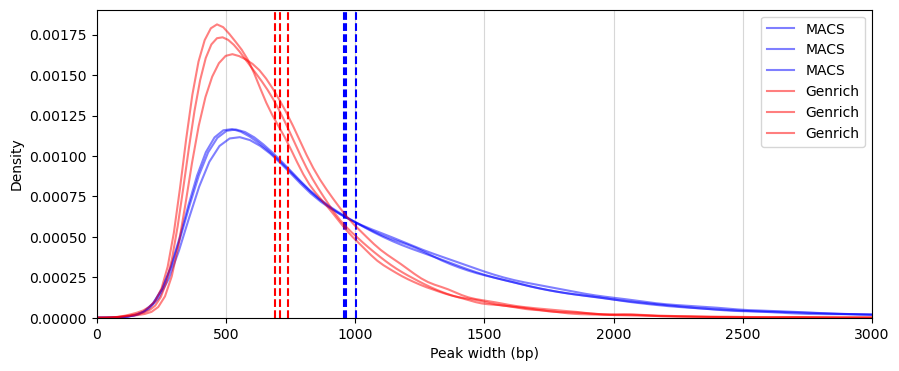

In [5]:
# note for Genrich, peaks thresholded by q value selects for wider peaks with larger q values
fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
for df in macs_dfs:
    sns.kdeplot(df['End']-df['Start'], color="blue", alpha=0.5, label="MACS")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="blue", linestyle='--')
for df in genrich_dfs:
    sns.kdeplot(df['End']-df['Start'], color="red", alpha=0.5, label="Genrich")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="red", linestyle='--')
axs.set_xlim(0,3000)
axs.set_xlabel("Peak width (bp)")
axs.set_ylabel("Density")
axs.grid(axis='x', alpha=0.5)  
# add legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)



peaks above q value: 40206
peaks below q value: 0
peaks above q value: 37431
peaks below q value: 0
peaks above q value: 42201
peaks below q value: 0


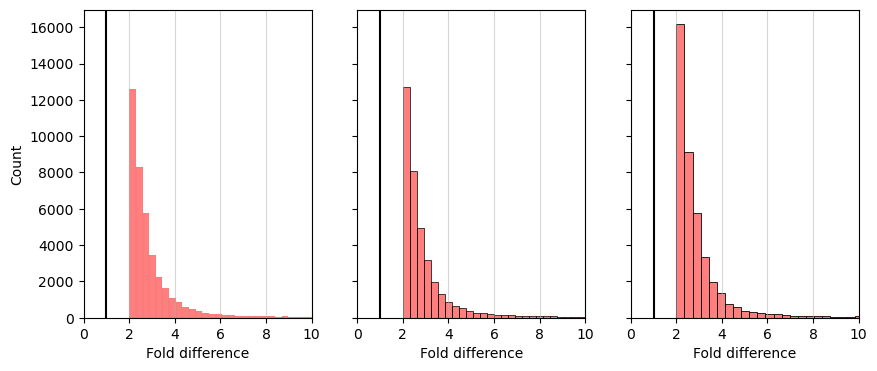

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for i,m in enumerate(macs_dfs):
    a = m['signalValue'][m['qValue'] > 1.3]
    b = m['signalValue'][m['qValue'] <= 1.3]
    sns.histplot(a, color="red", alpha=0.5, stat='count', bins=1000, ax=axs[i])
    sns.histplot(b, color="blue", alpha=0.5, stat='count', bins=5, ax=axs[i])
    axs[i].set_xlim(0,10)
    axs[i].axvline(x=1, color="black")
    axs[i].set_xlabel("Fold difference")
    axs[i].grid(axis='x', alpha=0.5)
    print("peaks above q value:", len(a))
    print("peaks below q value:", len(b))

# COMPARE SUMMITS (NOT PEAKS, WHICH IS THE ENTIRE INTERVAL CALLED BY METHOD)

In [7]:

# look at overlaps between methods within bioreps
macs_summit_overlaps, genrich_summit_overlaps = fn.get_summit_overlaps_between_method_within_reps(macs_dfs, genrich_dfs, dist_thresh)
print(macs_summit_overlaps)
print(genrich_summit_overlaps)
for i,m in enumerate(macs_summit_overlaps):
    print(f"MACS2: {m[0]} peaks, {m[1]*100:.2f}% overlap with Genrich peaks")
for i,m in enumerate(genrich_summit_overlaps):
    print(f"Genrich: {m[0]} peaks, {m[1]*100:.2f}% overlap with MACS2 peaks")

# look at overlaps within methods between bioreps
macs_summit_overlaps = fn.get_summit_overlaps_within_method_between_reps(macs_dfs, bioreps, dist_thresh)
genrich_summit_overlaps = fn.get_summit_overlaps_within_method_between_reps(genrich_dfs, bioreps, dist_thresh)

print(macs_summit_overlaps)
print(genrich_summit_overlaps)

[(40206, 0.9315027607819728), (37431, 0.742512890384975), (42201, 0.8698135115281629)]
[(46182, 0.8109653111601923), (29869, 0.9304965013894004), (40119, 0.9149530147810264)]
MACS2: 40206 peaks, 93.15% overlap with Genrich peaks
MACS2: 37431 peaks, 74.25% overlap with Genrich peaks
MACS2: 42201 peaks, 86.98% overlap with Genrich peaks
Genrich: 46182 peaks, 81.10% overlap with MACS2 peaks
Genrich: 29869 peaks, 93.05% overlap with MACS2 peaks
Genrich: 40119 peaks, 91.50% overlap with MACS2 peaks
[(40206, 37431, 15108), (40206, 42201, 15589), (37431, 42201, 15227)]
[(46182, 29869, 14277), (46182, 40119, 16413), (29869, 40119, 13060)]


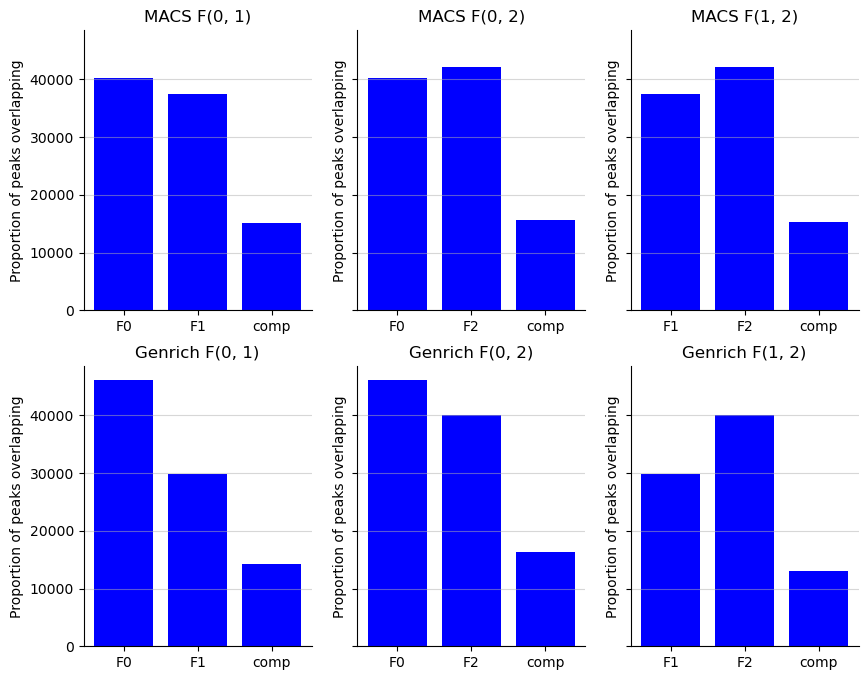

In [8]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)
for i,comp in enumerate(macs_summit_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[0][i].bar(range(len(comp)), comp, color="blue")
    axs[0][i].set_title(f"MACS F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(genrich_summit_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[1][i].bar(range(len(comp)), comp, color="blue")
    axs[1][i].set_title(f"Genrich F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()

# COMPARE PEAKS (NOT SUMMITS, WHICH IS THE APEX OF THE INTERVAL CALLED BY METHOD)

In [9]:
frac_overlap = 0.5 # fraction of peak overlap to be considered overlapping

macs_peaks_overlaps, genrich_peaks_overlaps = fn.get_peak_overlaps_between_method_within_reps(macs_dfs, genrich_dfs, frac_overlap)

print(macs_peaks_overlaps)
print(genrich_peaks_overlaps)
for i,m in enumerate(macs_peaks_overlaps):
    print(f"MACS2: {m[0]} peaks, {m[1]*100:.2f}% overlap with Genrich peaks")
for i,m in enumerate(genrich_peaks_overlaps):
    print(f"Genrich: {m[0]} peaks, {m[1]*100:.2f}% overlap with MACS2 peaks")

# look at overlaps within methods between bioreps

macs_peaks_overlaps = fn.get_peak_overlaps_within_method_between_reps(macs_dfs, bioreps, frac_overlap)
genrich_peaks_overlaps = fn.get_peak_overlaps_within_method_between_reps(genrich_dfs, bioreps, frac_overlap)

print(macs_peaks_overlaps)
print(genrich_peaks_overlaps)

[(40206, 0.8237079042928916), (37431, 0.6333253185861986), (42201, 0.7564749650482216)]
[(46182, 0.8798882681564246), (29869, 0.991094445746426), (40119, 0.9780403300181959)]
MACS2: 40206 peaks, 82.37% overlap with Genrich peaks
MACS2: 37431 peaks, 63.33% overlap with Genrich peaks
MACS2: 42201 peaks, 75.65% overlap with Genrich peaks
Genrich: 46182 peaks, 87.99% overlap with MACS2 peaks
Genrich: 29869 peaks, 99.11% overlap with MACS2 peaks
Genrich: 40119 peaks, 97.80% overlap with MACS2 peaks
[(40206, 37431, 14062), (40206, 42201, 14122), (37431, 42201, 13792)]
[(46182, 29869, 12062), (46182, 40119, 13245), (29869, 40119, 11002)]


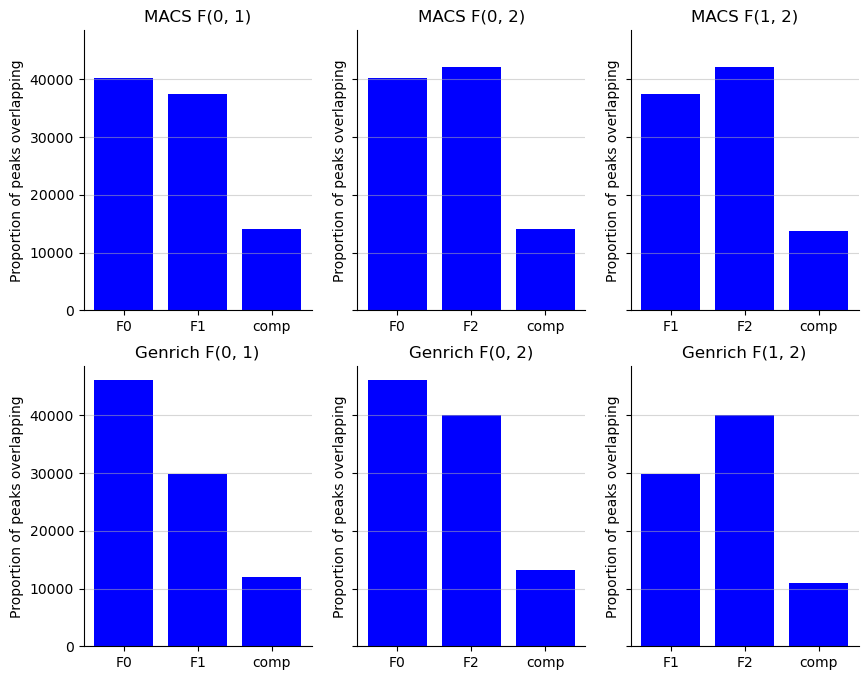

In [10]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)
for i,comp in enumerate(macs_peaks_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[0][i].bar(range(len(comp)), comp, color="blue")
    axs[0][i].set_title(f"MACS F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(genrich_peaks_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[1][i].bar(range(len(comp)), comp, color="blue")
    axs[1][i].set_title(f"Genrich F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()

In [11]:
p1 = pr.PyRanges(chromosomes=genrich_dfs[0].Chromosome,
                starts=genrich_dfs[0].Start,
                ends=genrich_dfs[0].End)
p2 = pr.PyRanges(chromosomes=genrich_dfs[1].Chromosome,
                    starts=genrich_dfs[1].Start,
                    ends=genrich_dfs[1].End)
p3 = pr.PyRanges(chromosomes=genrich_dfs[2].Chromosome,
                    starts=genrich_dfs[2].Start,
                    ends=genrich_dfs[2].End)

gr = {"p1":p1, "p2":p2, "p3":p3}

In [12]:
overlaps_per_rep = pr.count_overlaps(gr)
overlaps_per_rep = overlaps_per_rep.df
overlaps_per_rep['combined'] = overlaps_per_rep['p1'].astype(str) + overlaps_per_rep['p2'].astype(str) + overlaps_per_rep['p3'].astype(str)
# it looks like count_overlaps is counting overlaps b/t all instervals
# if all three replicates have an overlapping interval, pattern could look like this:
#       Chromosome	Start	End	    p1	p2	p3
# 7	    NMEL_chr_1	9079	9297	0	0	0
# 8	    NMEL_chr_1	9297	9309	1	0	0
# 9	    NMEL_chr_1	9309	9649	1	1	0
# 10	NMEL_chr_1	9649	10150	1	1	1
# 11	NMEL_chr_1	10150	10843	0	1	1
# 12	NMEL_chr_1	10843	10914	0	0	1
# 13	NMEL_chr_1	10914	16276	0	0	0
# where index 10 is interval in which all 3 peaks are overlapping, but since start/end points of the peaksare different,
# we can see that replicate 1 has the minimum starting point, and replicate 3 has the maximum ending point


In [13]:
overlaps_per_rep['Chromosome'].unique()
len(overlaps_per_rep[overlaps_per_rep['combined'] == '011'])

10161

In [14]:
def check_singleton(candidate):
    x = ['100', '010', '001']
    string = candidate['combined'].to_string(index=False)
    try:
        # return index of matching string
        return x.index(string)
    except ValueError:
        return -1

singleton_peaks = defaultdict(int) # peaks only supported by a single caller
doublet_peaks = [] # peaks supported by 2 callers with some interval overlap
triplet_peaks = [] # peaks supported by 3 callers with some interval overlap

for chrom in overlaps_per_rep['Chromosome'].unique():
    # if chrom == "NMEL_chr_1":
        # look only at specific chromosomes to avoid comparing comparing peak callers at chromosome endpoints
        df = overlaps_per_rep[overlaps_per_rep['Chromosome'] == chrom]
        df.reset_index(inplace=True, drop=False) # keep index in case useful for later
        # get candidate intervals using indices in which there's an interval with no peaks
        # these can then be parsed into intervals supported by 1, 2, or 3 replicates
        indices = np.array(df.index[df['combined'] == '000'])
        # print(indices)
        
        for i in range(len(indices)-1):
            # first deal with singleton regions, or single intervals flanked by regions of no peaks
            if indices[i+1] - indices[i] == 2:
                # candidate singleton, a 100, 010, or 001 flanked by 000
                candidate_singleton = df.iloc[[indices[i]+1]]
                singleton_type = check_singleton(candidate_singleton)
                if singleton_type != -1:
                    singleton_peaks[singleton_type] += 1
                else:
                    support_patterns = candidate_singleton['combined'].unique()
                    if '111' in support_patterns:
                        triplet_peaks.append([np.min(candidate_singleton['index']), np.max(candidate_singleton['index'])])
                    elif '110' in support_patterns or '101' in support_patterns or '011' in support_patterns:
                        doublet_peaks.append([np.min(candidate_singleton['index']), np.max(candidate_singleton['index'])])  
                    else:
                        print('candidate singleton error')      
            # second deal with larger candidate regions, containing intervals with support from 2+ replicates
            # although rarely, some of these regions contain intervals with only support from 1 replicate with
            # immediately adjacent endpoints
            elif indices[i+1] - indices[i] > 2:
                #multiple intervals involving more than 1 bioreplicate
                candidate_interval_df = df.iloc[list(range(indices[i]+1,indices[i+1]))]
                support_patterns = candidate_interval_df['combined'].unique()
                if '111' in support_patterns:
                    triplet_peaks.append([np.min(candidate_interval_df['index']), np.max(candidate_interval_df['index'])])
                elif '110' in support_patterns or '101' in support_patterns or '011' in support_patterns:
                    doublet_peaks.append([np.min(candidate_interval_df['index']), np.max(candidate_interval_df['index'])])
                else:
                    print('candidate interval had adjacent but nonoverlapping peaks')
            else:
                print("error")

candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent but nonoverlapping peaks
candidate interval had adjacent

In [15]:
print(singleton_peaks)
print(len(doublet_peaks))
print(len(triplet_peaks))
print(doublet_peaks[0:20])
print(triplet_peaks[0:20])

defaultdict(<class 'int'>, {2: 18494, 1: 10768, 0: 23139})
15398
8862
[[20, 22], [30, 38], [40, 42], [44, 46], [60, 64], [114, 116], [130, 132], [136, 138], [144, 146], [152, 154], [168, 170], [174, 176], [182, 184], [194, 196], [240, 246], [248, 250], [307, 309], [333, 335], [341, 343], [351, 355]]
[[8, 12], [48, 52], [76, 82], [84, 88], [98, 104], [160, 164], [220, 226], [234, 238], [254, 264], [268, 272], [276, 280], [282, 285], [289, 292], [300, 305], [317, 321], [363, 372], [417, 420], [430, 434], [442, 446], [448, 452]]


In [16]:
# for each interval containing support by three replicates, how many separate subintervals contain support by all 3?
summary = defaultdict(int)
for t in triplet_peaks:
    df = overlaps_per_rep.iloc[list(range(t[0], t[1]+1))]
    # only grab intervals supported by all 3 replicates
    df = df[df['combined'] == '111']
    if len(df) == 4:
        print(t)
        print(overlaps_per_rep.iloc[list(range(t[0]-1, t[1]+2))])
    summary[len(df)] += 1
summary

[125271, 125285]
        Chromosome    Start      End  p1  p2  p3 combined
125270  NMEL_chr_9  3072719  3075037   0   0   0      000
125271  NMEL_chr_9  3075037  3075220   0   1   0      010
125272  NMEL_chr_9  3075220  3075239   1   1   0      110
125273  NMEL_chr_9  3075239  3076142   1   1   1      111
125274  NMEL_chr_9  3076142  3076275   1   1   0      110
125275  NMEL_chr_9  3076275  3076328   1   1   1      111
125276  NMEL_chr_9  3076328  3076581   0   1   1      011
125277  NMEL_chr_9  3076581  3076919   1   1   1      111
125278  NMEL_chr_9  3076919  3077033   1   1   0      110
125279  NMEL_chr_9  3077033  3077401   1   1   1      111
125280  NMEL_chr_9  3077401  3077486   0   1   1      011
125281  NMEL_chr_9  3077486  3077658   0   1   0      010
125282  NMEL_chr_9  3077658  3077686   0   1   1      011
125283  NMEL_chr_9  3077686  3077699   0   0   1      001
125284  NMEL_chr_9  3077699  3078449   1   0   1      101
125285  NMEL_chr_9  3078449  3078451   1   0   0      1

defaultdict(int, {1: 8312, 2: 499, 3: 45, 5: 2, 4: 4})

In [57]:
# DOUBLE CHECK THIS, WHAT HAPPENS WHEN MULTIPLE 111 CATEGORY FOR PARTICULAR INTERVAL
# ACCOUNT FOR WITH TRIP_ID?

# make a dataframe containing all subintervals supported by all 3 replicates
trips_indices = [list(range(t[0],t[1]+1)) for t in triplet_peaks] # for each interval containing a triplet, get list of indices contianing all subintervals
trips_df = pd.DataFrame()
support_patterns = ['111']
# support_patterns = ['111', '110', '101', '011']

for i,t in enumerate(trips_indices):
    df = overlaps_per_rep.iloc[t]
    # within interval, grab out subinterval actually supported by all 3 replicates
    #df = df[df['combined'] == '111']
    df = df[df['combined'].isin(support_patterns)]
    # df['trip_id'] = i
    if not trips_df.empty:
        trips_df = pd.concat([trips_df, df], axis=0)
    else:
        trips_df = df

trips_df.reset_index(inplace=True, drop=True)
trips_df['trip_id'] = trips_df.index
# assert len(trips_df['combined'].unique()) == 1 and trips_df['combined'].unique()[0] == '111'
trips_df = trips_df[['Chromosome', 'Start', 'End', 'trip_id']]
print(trips_df)
print(len(trips_df))
print(len(trips_indices))
print(len(trips_df) - len(trips_indices))


             Chromosome  Start    End  trip_id
0            NMEL_chr_1   9649  10150        0
1            NMEL_chr_1  46160  47070        1
2            NMEL_chr_1  78398  79369        2
3            NMEL_chr_1  82392  82949        3
4            NMEL_chr_1  94976  95124        4
...                 ...    ...    ...      ...
9466   NMEL_unplaced_92   2170   2579     9466
9467  NMEL_unplaced_165   2193   3075     9467
9468  NMEL_unplaced_176   1888   2072     9468
9469  NMEL_unplaced_176   2546   3212     9469
9470  NMEL_unplaced_438   1154   1544     9470

[9471 rows x 4 columns]
9471
8862
609


In [58]:
# convert dataframes into pyranges for overlapping
# trips_pr = pr.PyRanges(trips_df.head(10))
trips_pr = pr.PyRanges(trips_df)
pile1 = pr.PyRanges(pileup_dfs[0])
pile2 = pr.PyRanges(pileup_dfs[1])
pile3 = pr.PyRanges(pileup_dfs[2])



In [59]:

pile1_trips = pile1.join(trips_pr, report_overlap=True, how='right')
pile2_trips = pile2.join(trips_pr, report_overlap=True, how='right')
pile3_trips = pile3.join(trips_pr, report_overlap=True, how='right')

pile1_trips = pile1_trips.df
pile2_trips = pile2_trips.df
pile3_trips = pile3_trips.df


In [60]:
# for each category of trip_id in tmp, find the maximum fold_diff and mean fold_diff

pile1_trips_summary = pile1_trips.groupby('trip_id').agg({'fold_diff': ['max', 'mean']})
pile2_trips_summary = pile2_trips.groupby('trip_id').agg({'fold_diff': ['max', 'mean']})
pile3_trips_summary = pile3_trips.groupby('trip_id').agg({'fold_diff': ['max', 'mean']})

# maxs may have fewer entries than this may be less than the trips_df if there are multiple rows with the same trip_id
maxs = np.column_stack((pile1_trips_summary.fold_diff['max'],
                    pile2_trips_summary.fold_diff['max'],
                    pile3_trips_summary.fold_diff['max']))
means = np.column_stack((pile1_trips_summary.fold_diff['mean'],
                    pile2_trips_summary.fold_diff['mean'],
                    pile3_trips_summary.fold_diff['mean']))


In [61]:
print(maxs.shape)
print(means.shape)
print(np.corrcoef(maxs, rowvar=False))
print(np.corrcoef(means, rowvar=False))


(9471, 3)
(9471, 3)
[[1.         0.95717501 0.95012997]
 [0.95717501 1.         0.95370085]
 [0.95012997 0.95370085 1.        ]]
[[1.         0.94660633 0.93724713]
 [0.94660633 1.         0.94374285]
 [0.93724713 0.94374285 1.        ]]


medians: [3.96325878 3.9954508  3.9523047 ]
means: [6.51580704 6.49709652 6.4859507 ]


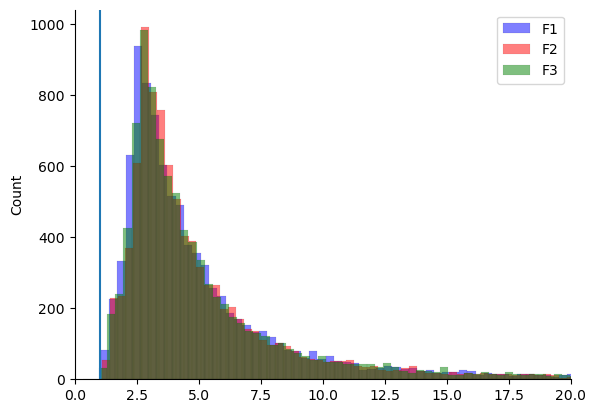

In [63]:
# are there systematic differences in fold differences across replicates?
print("medians:", np.median(maxs, axis=0))
print("means:", np.mean(maxs, axis=0))

sns.histplot(maxs[:,0], color="blue", alpha=0.5, label="F1")
sns.histplot(maxs[:,1], color="red", alpha=0.5, label="F2")
sns.histplot(maxs[:,2], color="green", alpha=0.5, label="F3")
plt.xlim(0,20)
plt.axvline(x=1)
plt.legend()
sns.despine()


In [105]:
tmp1

,Chromosome,Start,End,experimental,control,-log(p),fold_diff,midpoint,Start_b,End_b,trip_id,Overlap
0,NMEL_chr_1,9649,9667,143.0,46.426441,3.480473,3.080141,9658.0,9649,10150,0,18
1,NMEL_chr_1,9667,9669,162.0,46.426441,4.076585,3.489391,9668.0,9649,10150,0,2
2,NMEL_chr_1,9669,9681,378.0,46.426441,9.540387,8.141912,9675.0,9649,10150,0,12
3,NMEL_chr_1,9681,9769,366.0,46.426441,9.286664,7.883439,9725.0,9649,10150,0,88
4,NMEL_chr_1,9769,9773,403.0,46.426441,10.054862,8.680398,9771.0,9649,10150,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
323130,NMEL_unplaced_438,1535,1538,567.0,509.853058,1.672589,1.112085,1536.5,1154,1544,9470,3
323131,NMEL_unplaced_438,1538,1540,566.0,521.083313,1.272642,1.086199,1539.0,1154,1544,9470,2
323132,NMEL_unplaced_438,1540,1541,566.0,525.575378,1.140391,1.076915,1540.5,1154,1544,9470,1
323133,NMEL_unplaced_438,1541,1543,563.0,518.837219,1.250951,1.085119,1542.0,1154,1544,9470,2


In [ ]:
maxs = []
means = []

# pile1 = pr.PyRanges(pileup_dfs[0])
# pile2 = pr.PyRanges(pileup_dfs[1])
# pile3 = pr.PyRanges(pileup_dfs[2])

for t in triplet_peaks[0:10]:
    df = overlaps_per_rep.iloc[list(range(t[0], t[1]+1))]
    # only grab intervals supported by all 3 replicates
    df = df[df['combined'] == '111']
    # CURRENTLY IGNORING INTERVALS WITH MULTIPLE INTERVALS OF SUPPORT FROM 3 REPLICATES
    if len(df) > 1:
        continue
    chrom = df['Chromosome'].unique()[0]

    p = pr.PyRanges(df)
    pile1 = pr.PyRanges(pileup_dfs[0][pileup_dfs[0]['Chromosome'] == chrom])
    pile2 = pr.PyRanges(pileup_dfs[1][pileup_dfs[1]['Chromosome'] == chrom])
    pile3 = pr.PyRanges(pileup_dfs[2][pileup_dfs[2]['Chromosome'] == chrom])    

    # pile1 = pr.PyRanges(pileup_dfs[0][(pileup_dfs[0]['Chromosome'] == chrom) &
    #                                   (pileup_dfs[0]['Start'] >= np.min(df['Start'])) &
    #                                     (pileup_dfs[0]['End'] <= np.max(df['End']))])
    # pile2 = pr.PyRanges(pileup_dfs[1][(pileup_dfs[1]['Chromosome'] == chrom) & 
    #                                   (pileup_dfs[1]['Start'] >= np.min(df['Start'])) &
    #                                 (pileup_dfs[1]['End'] <= np.max(df['End']))])
    # pile3 = pr.PyRanges(pileup_dfs[2][(pileup_dfs[2]['Chromosome'] == chrom) &
    #                                   (pileup_dfs[2]['Start'] >= np.min(df['Start'])) &
    #                                   (pileup_dfs[2]['End'] <= np.max(df['End']))])    

    # print(df['End']-df['Start'])
    # df.head()
    fold_diffs = [np.array(pile1.overlap(p).fold_diff), 
                  np.array(pile2.overlap(p).fold_diff), 
                  np.array(pile3.overlap(p).fold_diff)]


    maxs.append([np.max(x) for x in fold_diffs])
    means.append([np.mean(x) for x in fold_diffs])



In [ ]:
df


,Chromosome,Start,End,p1,p2,p3,combined
270,NMEL_chr_1,290990,292012,1,1,1,111


In [ ]:
len(triplet_peaks)

8870

In [ ]:
# p1 = pr.PyRanges(genrich_dfs[0])
# p1 = pr.PyRanges(genrich_dfs[1])
# p1 = pr.PyRanges(genrich_dfs[2])
# gr = {"p1":p1, "p2":p2, "p3":p3}
# overlaps_per_rep = pr.count_overlaps(gr)


In [ ]:
overlaps_per_rep

,Chromosome,Start,End,p1,p2,p3,combined
0,NMEL_chr_1,464,963,1,0,0,100
1,NMEL_chr_1,963,1694,0,0,0,000
2,NMEL_chr_1,1694,2318,0,0,1,001
3,NMEL_chr_1,2318,6189,0,0,0,000
4,NMEL_chr_1,6189,6827,0,1,0,010
...,...,...,...,...,...,...,...
226059,NMEL_unplaced_2954,784,787,0,1,1,011
226060,NMEL_unplaced_2954,787,909,0,0,1,001
226061,NMEL_unplaced_2963,126,710,1,0,0,100
226062,NMEL_unplaced_2964,511,948,0,1,0,010


In [ ]:
genrich_dfs[0]

,Chromosome,Start,End,name,score,strand,signalValue,pValue,qValue,peak,peak_coord
125827,NMEL_chr_1,464,963,peak_125827,1000,.,668.323669,4.247956,2.387169,314,778
125830,NMEL_chr_1,9297,10150,peak_125830,1000,.,3491.588135,10.706824,8.108179,501,9798
125839,NMEL_chr_1,21190,21538,peak_125839,851,.,296.311218,2.358975,1.004378,87,21277
125842,NMEL_chr_1,26482,27367,peak_125842,545,.,482.490051,3.512384,1.819621,427,26909
125843,NMEL_chr_1,35789,36503,peak_125843,256,.,182.803757,2.664666,1.208686,474,36263
...,...,...,...,...,...,...,...,...,...,...,...
1779,NMEL_unplaced_983,226,1271,peak_1779,713,.,744.705261,3.677490,1.944565,462,688
49922,NMEL_unplaced_990,252,920,peak_49922,1000,.,860.308350,4.045753,2.227037,423,675
49919,NMEL_unplaced_995,118,1829,peak_49919,1000,.,13678.864258,22.096611,18.875910,486,604
49915,NMEL_unplaced_998,1216,1841,peak_49915,450,.,281.193176,2.539403,1.123622,301,1517


In [ ]:
x = [1,4]
# use a python function to get list of integers between x[0] and x[1]




In [ ]:
print(p1.coverage(p2, overlap_col="C", fraction_col="F").head())
print(p1.coverage(p3, overlap_col="C", fraction_col="F").head())
print(p2.coverage(p3, overlap_col="C", fraction_col="F").head())



+--------------+-----------+-----------+-----------+-------------+
| Chromosome   |     Start |       End |         C |           F |
| (category)   |   (int64) |   (int64) |   (int64) |   (float64) |
|--------------+-----------+-----------+-----------+-------------|
| NMEL_chr_1   |       464 |       963 |         0 |    0        |
| NMEL_chr_1   |      9297 |     10150 |         1 |    0.985932 |
| NMEL_chr_1   |     21190 |     21538 |         0 |    0        |
| NMEL_chr_1   |     26482 |     27367 |         0 |    0        |
| NMEL_chr_1   |     35789 |     36503 |         1 |    0.495798 |
| NMEL_chr_1   |     36753 |     37234 |         1 |    1        |
| NMEL_chr_1   |     37568 |     37953 |         1 |    1        |
| NMEL_chr_1   |     38068 |     38751 |         1 |    1        |
+--------------+-----------+-----------+-----------+-------------+
Unstranded PyRanges object has 8 rows and 5 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
+---

In [ ]:
genrich_multi_df.head()

,Chromosome,Start,End,name,score,strand,signalValue,pValue,qValue,peak,peak_coord
142642,NMEL_chr_1,464,963,peak_142642,1000,.,669.542114,4.427304,2.803614,250,714
142643,NMEL_chr_1,1604,2234,peak_142643,547,.,344.859772,3.484181,2.017229,223,1827
142644,NMEL_chr_1,3694,3804,peak_142644,173,.,19.080345,1.444832,0.497410,67,3761
142645,NMEL_chr_1,4884,5262,peak_142645,193,.,72.814713,1.755602,0.708028,205,5089
142646,NMEL_chr_1,6189,6827,peak_142646,571,.,364.515930,2.030947,0.902151,254,6443


In [ ]:
p1 = pr.PyRanges(genrich_dfs[0])
p1

,Chromosome,Start,End,name,score,strand,signalValue,pValue,qValue,peak,peak_coord
0,NMEL_chr_1,464,963,peak_125827,1000,.,668.323669,4.247956,2.387169,314,778
1,NMEL_chr_1,9297,10150,peak_125830,1000,.,3491.588135,10.706824,8.108179,501,9798
2,NMEL_chr_1,21190,21538,peak_125839,851,.,296.311218,2.358975,1.004378,87,21277
3,NMEL_chr_1,26482,27367,peak_125842,545,.,482.490051,3.512384,1.819621,427,26909
4,NMEL_chr_1,35789,36503,peak_125843,256,.,182.803757,2.664666,1.208686,474,36263
...,...,...,...,...,...,...,...,...,...,...,...
46177,NMEL_unplaced_2952,243,941,peak_1705,501,.,349.489532,2.896384,1.370704,348,591
46178,NMEL_unplaced_2953,177,460,peak_1704,1000,.,4733.391602,80.986115,76.405922,179,356
46179,NMEL_unplaced_2954,15,784,peak_49812,659,.,506.486572,3.060408,1.488602,233,248
46180,NMEL_unplaced_2963,126,710,peak_49876,304,.,177.729736,2.464328,1.071229,231,357


In [ ]:
# make new data frame that has coordinates of MACS peaks as Start and End, required by pyranges
macs_summit_df = macs_df[['Chromosome', 'peak_coord_m', 'signalValue_m']]
# make a new column that has value of peak_coord_m + 1
macs_summit_df['peak_coord_m_1'] = macs_summit_df['peak_coord_m'] + 1
macs_summit_df = macs_summit_df[['Chromosome', 'peak_coord_m', 'peak_coord_m_1', 'signalValue_m']]
macs_summit_df.columns = ['Chromosome', 'Start', 'End', 'signalValue_m']

macs_pr = pr.PyRanges(macs_summit_df)
pileup_pr = pr.PyRanges(pileup_df)


NameError: name 'macs_df' is not defined

In [ ]:
genrich_fold_diff = np.array(pileup_pr.overlap(macs_pr).fold_diff)
macs_fold_diff = np.array(macs_pr.signalValue_m)

# print(len(genrich_fold_diff), len(macs_fold_diff))
print(np.corrcoef(genrich_fold_diff, macs_fold_diff))


[[1.         0.95918524]
 [0.95918524 1.        ]]


[[1.         0.95918524]
 [0.95918524 1.        ]]
4472
35734


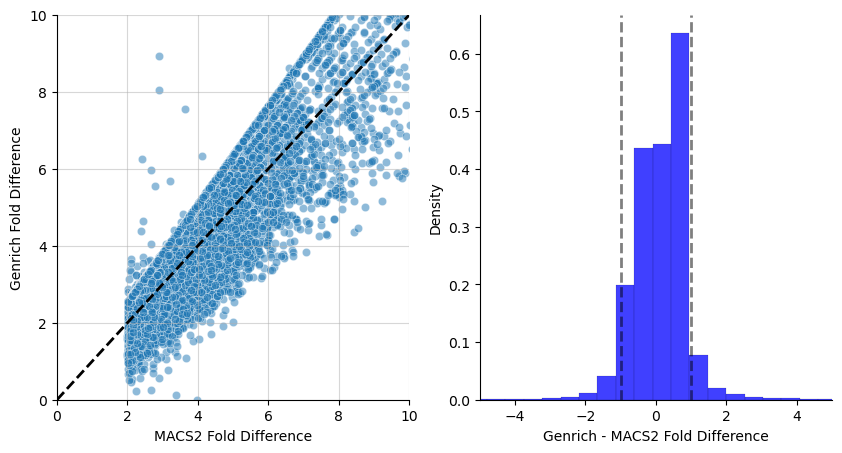

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# sns.scatterplot(x=macs_fold_diff, y=genrich_fold_diff, alpha=0.5, ax=axs[0])
sns.scatterplot(x=macs_fold_diff, y=genrich_fold_diff, alpha=0.5, ax=axs[0])
axs[0].set_xlabel("MACS2 Fold Difference", fontsize=10)
axs[0].set_ylabel("Genrich Fold Difference", fontsize=10)
axs[0].set_xlim(0,10)
axs[0].set_ylim(0,10)
# add diagonal line
axs[0].plot([0, 60], [0, 60], linewidth=2, color='black', linestyle='--')
# add grid lines
axs[0].grid(True, alpha=0.5)

sns.histplot(np.array(genrich_fold_diff)-np.array(macs_fold_diff), color="blue", bins=300, stat='density', ax=axs[1])
axs[1].set_xlim(-5,5)
axs[1].set_xlabel("Genrich - MACS2 Fold Difference", fontsize=10)
axs[1].axvline(x=1, color='black', linestyle='--', alpha=0.5, linewidth=2)
axs[1].axvline(x=-1, color='black', linestyle='--', alpha=0.5, linewidth=2)

sns.despine()   

print(np.corrcoef(genrich_fold_diff, macs_fold_diff))
print(sum(abs(genrich_fold_diff - macs_fold_diff) > 1))
print(sum(abs(genrich_fold_diff - macs_fold_diff) <= 1))

In [ ]:
m = pr.PyRanges(chromosomes=macs_df.chromosome,
                starts=macs_df.peak_coord_m - 10,
                ends=macs_df.peak_coord_m + 10)
p = pr.PyRanges(chromosomes=pileup_df.chr,
                starts=pileup_df.midpoint - 10,
                ends=pileup_df.midpoint + 10)

In [ ]:
print(len(m), len(p), len(m.overlap(p)))

1884 519936 1857
